<a href="https://colab.research.google.com/github/sciencebyAJ/oet_gf_ti/blob/main/time_integration_gap_filling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sciencebyAJ/oet_gf_ti.git

Cloning into 'oet_gf_ti'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 104 (delta 31), reused 11 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 18.07 MiB | 6.64 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
cd oet_gf_ti/

/content/oet_gf_ti


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [ ]:
import pandas as pd
import glob
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from scipy.stats import tukey_hsd

from scipy.interpolate import Akima1DInterpolator, CubicSpline, KroghInterpolator
import requests
import datetime
import matplotlib.pyplot as plt
import json
from google.colab import userdata

Import custom libraries

In [ ]:
import src.time_integration as ti
import src.stats as stats

Define global variables

In [ ]:
SITE_PATH   = 'data/'
OUT_PATH   = 'results/'
openETapikey = userdata.get('open_et_api_key')
drive_ti_outpath = userdata.get('drive_ti_outath')
verbose=True
update_data=True


Custom interpolation function

In [ ]:
def interp_var(in_df,varname = 'clear_sky_EToF',refeto = 'site'):
    all_df = in_df.copy()
    all_df['xs']=np.arange(0,all_df.shape[0])+1
    all_df['x'] = all_df['xs'].mask(np.isnan(all_df[varname]), np.nan)
    all_df['week']=all_df.index.isocalendar().week
    # linear interpolation
    all_df[varname+'_linear']=all_df[varname].interpolate('linear',limit=32,limit_area='inside', limit_direction='both')
    # akima interpolation (e.g. rolling spline)
    x = np.array(all_df['x'])[~np.isnan(all_df['x'])]
    y = np.array(all_df[varname])[~np.isnan(all_df[varname])]
    xs = np.array(all_df['xs'])
    y_akima = Akima1DInterpolator(x, y, method="akima")(xs)
    all_df[varname+'_Akima']=y_akima
    all_df[varname+'_Akima']=all_df[varname+'_Akima'].mask(np.isnan(all_df[varname+'_linear']), np.nan)
    # climatology interpolation
    df_clim = all_df[[varname,'x']].copy()
    df_clim[varname+'rm']=df_clim[varname].rolling(32,1,center=True).mean()
    df_nonans = df_clim[[varname+'rm','x']].dropna()
    X = np.array(df_nonans.x)
    fit = np.polyfit(X, df_nonans[varname+'rm'], 1)
    fit_fn = np.poly1d(fit)
    all_df[varname+'linear_trend']= fit_fn(xs)
    all_df[varname+'iav']=df_clim[varname+'rm']-all_df[varname+'linear_trend']
    serClimModel = all_df[varname+'iav'].rolling(32,1,center=True).mean().groupby([all_df.index.isocalendar().week]).mean()
    # serClimModel = all_df[varname].rolling(32,1,center=True).mean().groupby([all_df.index.isocalendar().week]).mean()
    var_clim_dict = serClimModel.to_dict()
    all_df[varname+'_clim']=all_df['week'].map(var_clim_dict)
    all_df[varname+'_noclim']=all_df[varname]-all_df[varname+'_clim']
    all_df[varname+'noclim_fill'] = all_df[varname+'_noclim'].interpolate(method='linear', limit=32,limit_area='inside', limit_direction='both')
    all_df[varname+'_clim_fill'] =all_df[varname+'noclim_fill']+all_df[varname+'_clim']

    # now conert back to ETo
    if refeto == 'gridMET':
      all_df[varname+'_linear_ET']=all_df[varname+'_linear']*all_df['eto']
      all_df[varname+'_clim_fill_ET']=all_df[varname+'_clim_fill']*all_df['eto']
      all_df[varname+'_Akima_ET']=all_df[varname+'_Akima']*all_df['eto']
    elif refeto == 'site':
      try:
        all_df[varname+'_linear_ET']=all_df[varname+'_linear']*all_df['ASCE_ETo']
        all_df[varname+'_clim_fill_ET']=all_df[varname+'_clim_fill']*all_df['ASCE_ETo']
        all_df[varname+'_Akima_ET']=all_df[varname+'_Akima']*all_df['ASCE_ETo']
      except:
        all_df[varname+'_linear_ET']=all_df[varname+'_linear']*all_df['gridMET_ETo']
        all_df[varname+'_clim_fill_ET']=all_df[varname+'_clim_fill']*all_df['gridMET_ETo']
        all_df[varname+'_Akima_ET']=all_df[varname+'_Akima']*all_df['gridMET_ETo']
      pass

    else:
      all_df[varname+'_linear_ET']=all_df[varname+'_linear']*all_df['gridMET_ETo']
      all_df[varname+'_clim_fill_ET']=all_df[varname+'_clim_fill']*all_df['gridMET_ETo']
      all_df[varname+'_Akima_ET']=all_df[varname+'_Akima']*all_df['gridMET_ETo']

    return all_df



time_ags = ['MAM','JJA','SON','DJF','Annual','Growing']
time_ag_dict ={'MAM':[3,4,5],
              'JJA':[6,7,8],
              'SON':[9,10,11],
              'DJF':[12,1,2],
              'Annual':[1,2,3,4,5,6,7,8,9,10,11,12],
              'Growing':[4,5,6,7,8,9,10]}



Run analysis step-by-step

In [ ]:
if update_data:
  all_stats_df = pd.DataFrame(columns=['Site_id','Obs_freq','Obs_freq_rep','Fill_Method','Temp','Bias', 'MAE', 'RMSE', 'R2', 'KT','Mean_ET'])

  for filename in glob.glob('data/*.csv'):
    print(filename)
    try:
      tower_i = ti.get_tower_data(filename.split('/')[-1], SITE_PATH, OUT_PATH, openETapikey,debug=False)
      site_avail=True
    except:
      site_avail=False
      print('\t'+'site not available')
    if site_avail:
      all_df = tower_i.site_all_df.copy()
      all_df = interp_var(all_df,varname = 'clear_sky_EToF')
      all_df['openetof']=all_df['et']/all_df['eto']
      all_df = interp_var(all_df,varname = 'openetof')

      for i in [4, 8,16,32,64]:
        for j in np.arange(i):
          out_list = ['freq_'+str(i), 'EToF_filt_'+str(i)+'_'+str(j)]
          varname_ij = f'EToF_filtered{str(i)}_{str(j)}'
          if verbose:
            print('\t'+varname_ij)
          all_df_ij = all_df.copy()
          all_df_ij = interp_var(all_df_ij,varname = varname_ij)
          if j ==0:
            all_df_ij.to_csv(OUT_PATH+'tables/'+tower_i.site_id+'_'+varname_ij+'data_for_figs.csv')
            all_df_ij.to_csv(drive_ti_outpath+'/'+tower_i.site_id+'_'+varname_ij+'data_for_figs.csv')

          for fmod in ['linear','Akima','clim_fill']:
            varname_ijm = varname_ij+'_'+fmod+'_ET'
            for temp_ag in time_ags:
              all_df_ij_temp = all_df_ij.loc[all_df_ij.index.month.isin(time_ag_dict[temp_ag])]
              try:
                out_stats = stats.get_summary_stats(all_df_ij_temp[varname_ijm], all_df_ij_temp['ET_fill'])#ET_fill
                mean_et = [all_df_ij_temp.ET_corr.mean()]
                all_stats_df.loc[len(all_stats_df.index)]=[tower_i.site_id]+out_list+[fmod,temp_ag]+out_stats+mean_et
              except:
                print('\t\t'+varname_ijm+' not all stats able to be computed')
                continue
      all_stats_df.loc[all_stats_df['Site_id']==tower_i.site_id].to_csv(OUT_PATH+'tables/'+tower_i.site_id+'_stats.csv')
      all_stats_df.loc[all_stats_df['Site_id']==tower_i.site_id].to_csv(drive_ti_outpath+'/'+tower_i.site_id+'_stats.csv')

      #Figures
      plt.style.use('seaborn-v0_8')
      plt.figure(figsize=(6,2.5))
      tower_i.site_all_df.ET_fill.plot(color='lightgray',label='')#ET_corr
      tower_i.site_all_df.et.plot(style='.',label='ET$_{OpenET}$')
      tower_i.site_all_df.clear_sky_ET.plot(style='.',label='ET$_{EC_{clear sky}}$')
      tower_i.site_all_df.ET_corr16_0.plot(style='.',label='ET$_{EC_{16}}$')
      tower_i.site_all_df.ET_corr32_0.plot(style='.',label='ET$_{EC_{32}}$')
      tower_i.site_all_df.ET_corr64_0.plot(style='.',label='ET$_{EC_{64}}$')
      plt.title(tower_i.site_id)
      plt.legend(frameon=False,ncol=1,bbox_to_anchor=(1,1))
      plt.xlabel('')
      plt.ylabel('ET (mm/day)')
      plt.tight_layout()
      plt.savefig(OUT_PATH+'figures/'+tower_i.site_id+'_ET_clear_sky.png')

      plt.style.use('ggplot')
      plt.figure(figsize=(6,2.5))
      varname1 = 'clear_sky_EToF'
      varname = 'openetof'
      # tower_i.site_all_df.ASCE_ETo.plot(color='gray',label='',lw=5)
      tower_i.site_all_df.ET_corr.plot(style='.',color='lightgray',label='')
      all_df['clear_sky_EToF'+'_linear_ET'].plot(style='.',label='EC lin')
      all_df[varname+'_linear_ET'].plot(style='.',label='OpenET lin')
      all_df['clear_sky_EToF'+'_Akima_ET'].plot(style='.',label='Akima')
      all_df[varname+'_clim_fill_ET'].plot(style='.',c='purple',markersize=6,label=varname +' Clim Fill')
      tower_i.site_all_df.et.plot(style='.',label='ET$_{OpenET}$')
      tower_i.site_all_df.clear_sky_ET.plot(style='.',label='ET$_{EC_{clear sky}}$')
      plt.title(tower_i.site_id)
      plt.legend(frameon=False,ncol=1,bbox_to_anchor=(1,1))
      plt.xlabel('')
      plt.ylabel('ET (mm/day)')
      plt.tight_layout()
      plt.savefig(OUT_PATH+'figures/'+tower_i.site_id+'_interp_method_comp.png')

  all_stats_df.to_csv(OUT_PATH + 'tables/' + 'all_site_stats.csv')
  all_stats_df.to_csv(drive_ti_outpath + '/' + 'all_site_stats.csv')
# all_stats_df.to_csv(OUT_PATH + 'tables/' + 'all_site_stats.csv')
# all_stats_df.to_csv(drive_ti_outpath + '/' + 'all_site_stats.csv')
try:
  all_stats_df.drop(columns=['Unnamed: 0'],inplace=True)
except:
  pass


data/US-Me2_daily_data.csv
	site not available
data/US-Ne1_daily_data.csv
	site not available
data/US-MMS_daily_data.csv
	site not available
data/US-Ne3_daily_data.csv
	site not available
data/US-Ne2_daily_data.csv
	site not available
data/US-Ro1_daily_data.csv
	site not available
data/US-Ro4_daily_data.csv
	site not available
data/US-GLE_daily_data.csv
	site not available
data/US-ARM_daily_data.csv
	site not available


In [ ]:
all_stats_df = pd.read_csv(drive_ti_outpath + '/' + 'all_site_stats.csv')

In [ ]:
three_site_df = all_stats_df.loc[all_stats_df.Site_id.isin(['US-ARM','US-Ne1','US-Ro4'])]
# three_site_df.drop(columns=['Unnamed: 0'],inplace=True)
for var in ['Bias','MAE','RMSE']:
  three_site_df[var+'_norm'] = three_site_df[var]/three_site_df['Mean_ET']

<ipython-input-13-c9c38186e15e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_site_df[var+'_norm'] = three_site_df[var]/three_site_df['Mean_ET']
<ipython-input-13-c9c38186e15e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_site_df[var+'_norm'] = three_site_df[var]/three_site_df['Mean_ET']
<ipython-input-13-c9c38186e15e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
for i in df.columns.unique():
  print(i)

Rn
theta_6
theta_mean
sw_out
theta_14
TA_PI_F_1_2_1
H_1_1_1
theta_8
theta_3
theta_15
wd
WS_2_1_1
WS_1_1_1
theta_16
theta_4
theta_9
TA_PI_F_1_1_1
P_PI_F_1_1_1
theta_5
theta_2
ws
LE_PI_F_1_1_1
theta_1
TA_PI_F_1_4_1
WS_1_3_1
theta_13
H
theta_11
G
TA_PI_F_1_3_1
RH_PI_F_1_3_1
WS_1_2_1
theta_12
LE_1_1_1
t_avg
LE
P_PI_F_2_2_1
RH_PI_F_1_1_1
rh
sw_in
RH_PI_F_1_2_1
RH_PI_F_1_4_1
lw_out
theta_7
theta_10
lw_in
H_PI_F_1_1_1
t_min
t_max
G_subday_gaps
H_subday_gaps
ppt
Rn_subday_gaps
LE_subday_gaps
rso
flux
energy
ebc_cf
H_corr
ebr_corr
LE_corr
flux_corr
ebr
ebr_5day_clim
ET
ET_corr
gridMET_ETr
gridMET_ETo
gridMET_prcp
EToF
EToF_filtered
ET_fill
ET_gap
ET_fill_val
et
eto
clear_sky_EToF
clear_sky_ET
ET_corr8_0
EToF_filtered8_0
ET_corr8_1
EToF_filtered8_1
ET_corr8_2
EToF_filtered8_2
ET_corr8_3
EToF_filtered8_3
ET_corr8_4
EToF_filtered8_4
ET_corr8_5
EToF_filtered8_5
ET_corr8_6
EToF_filtered8_6
ET_corr8_7
EToF_filtered8_7
ET_corr16_0
EToF_filtered16_0
ET_corr16_1
EToF_filtered16_1
ET_corr16_2
EToF_filter

<ipython-input-176-cd42eca34587>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['lin_interp']=filtered_df.EToFmvwind.interpolate('linear',limit=32,limit_area='inside', limit_direction='both')
<ipython-input-176-cd42eca34587>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_2['lin_interp2']=filtered_2.EToFmvwind.interpolate('linear',limit=32,limit_area='inside', limit_direction='both')
<ipython-input-176-cd42eca34587>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy

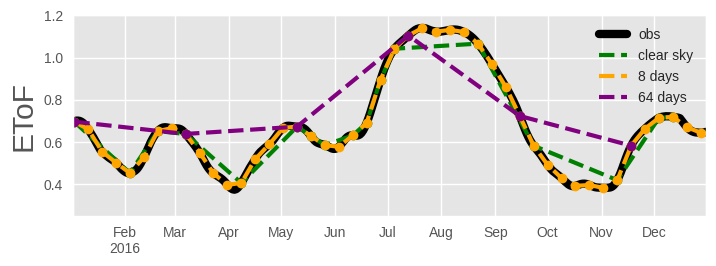

In [ ]:
df = pd.read_csv('/content/oet_gf_ti/results/tables/US-Ne1_EToF_filtered32_0data_for_figs.csv')
# df = pd.read_csv('/content/oet_gf_ti/results/tables/US-Ne3_EToF_filtered32_0data_for_figs.csv')

df.drop(columns=['Unnamed: 0'],inplace=True)
df.set_index('date',inplace=True)
df.index = pd.to_datetime(df.index)
df_ss = df.loc[df.index.year==2016]
var_test2 = 'EToF_filtered8_1'
var_test = 'EToF_filtered64_1'
df_ss = df_ss[['EToF_filtered','clear_sky_EToF',var_test,var_test2]]
df_ss['EToFmvwind']=df_ss.EToF_filtered.rolling(8,4,center=True).mean().rolling(32,4,center=True).mean()
filtered_df = df_ss[df_ss['clear_sky_EToF'].notna()]
filtered_df['lin_interp']=filtered_df.EToFmvwind.interpolate('linear',limit=32,limit_area='inside', limit_direction='both')
filtered_2 = df_ss[df_ss[var_test].notna()]
filtered_2['lin_interp2']=filtered_2.EToFmvwind.interpolate('linear',limit=32,limit_area='inside', limit_direction='both')

filtered_3 = df_ss[df_ss[var_test2].notna()]
filtered_3['lin_interp3']=filtered_3.EToFmvwind.interpolate('linear',limit=32,limit_area='inside', limit_direction='both')

# df_ss['lin_interp']=filtered_df['lin_interp']

plt.figure(figsize=(7.5,3))
df_ss.EToFmvwind.plot(c='k',label='obs',lw=6)

filtered_df.EToFmvwind.plot(c='green',style='o',label='')
filtered_df['lin_interp'].plot(style='--',c='green',label='clear sky',lw=3)


filtered_3.EToFmvwind.plot(c='orange',style='o',label='')
filtered_3['lin_interp3'].plot(style='--',c='orange',label='8 days',lw=3)

filtered_2.EToFmvwind.plot(c='purple',style='o',label='')
filtered_2['lin_interp2'].plot(style='--',c='purple',label='64 days',lw=3)





plt.legend()

plt.rcParams.update({'font.size': 18})

plt.ylim([0.25,1.2])
plt.ylabel('EToF'); plt.xlabel('')
plt.tight_layout()
plt.savefig('clear_sky_etof_errors.png',dpi=300)

In [ ]:
three_site_df_ss = three_site_df[['Site_id','Obs_freq','Obs_freq_rep','Fill_Method','Temp','Bias_norm', 'MAE_norm','R2']]

In [ ]:
three_site_df_ss.to_csv(drive_ti_outpath + '/' + 'ag_site_stats.csv')
three_site_df_ss.to_csv(OUT_PATH + 'tables/' + 'ag_site_stats.csv')

In [ ]:
three_site_df_ss.head()

,Site_id,Obs_freq,Obs_freq_rep,Fill_Method,Temp,Bias_norm,MAE_norm,R2
0,US-ARM,freq_8,EToF_filt_8_0,linear,MAM,0.012274,0.063771,0.943954
1,US-ARM,freq_8,EToF_filt_8_0,linear,JJA,-0.008702,0.098940,0.855721
2,US-ARM,freq_8,EToF_filt_8_0,linear,SON,0.007354,0.117311,0.897415
3,US-ARM,freq_8,EToF_filt_8_0,linear,DJF,-0.003684,0.125707,0.932510
4,US-ARM,freq_8,EToF_filt_8_0,linear,Annual,0.001593,0.092827,0.941332


In [ ]:
# tower_i.site_all_df.ET_fill.plot(color='lightgray',label='')#ET_corr
# tower_i.site_all_df.ET_corr.plot(color='k',style='o',label='')#ET_corr


In [ ]:
three_site_df.Fill_Method.unique()

array(['linear', 'Akima', 'clim_fill'], dtype=object)

In [ ]:
rename_labels = {'freq_8':'8',
                 'freq_16':'16',
                 'freq_32':'32',
                 'freq_64':'64'}


rename_method_labels = {'linear':'Linear',
                        'Akima':'Akima',
                        'clim_fill':'Signal Decomp'}



In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

<ipython-input-22-937996210bb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_site_df_ss_linear['Obs_freq'] = three_site_df_ss_linear.Obs_freq.map(rename_labels)


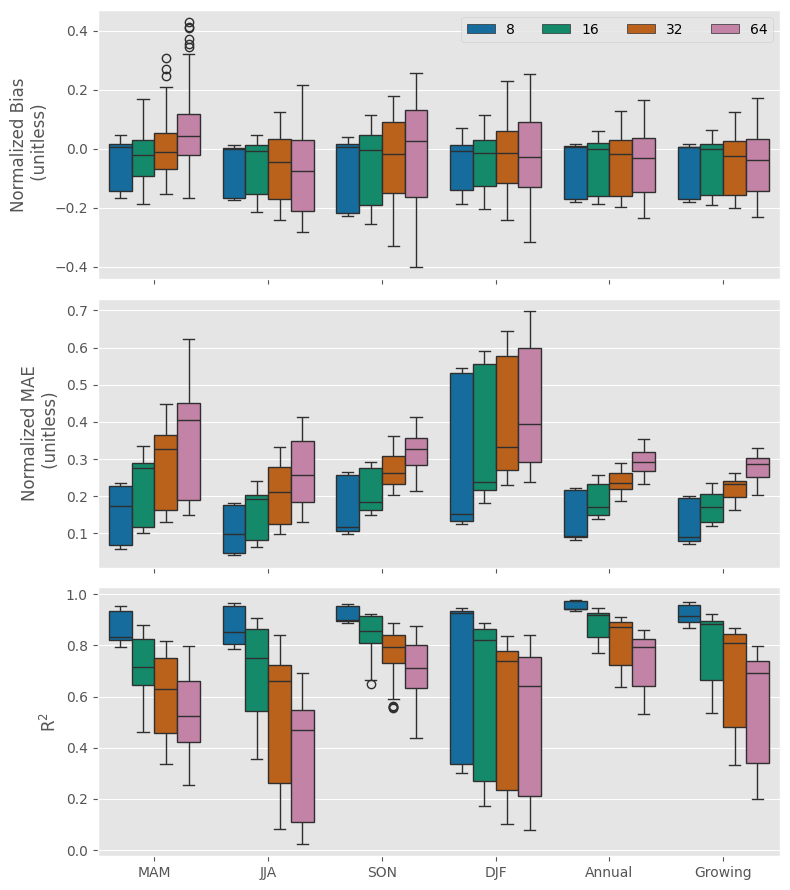

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-colorblind')
# Filter the DataFrame
three_site_df_ss_linear = three_site_df_ss.loc[three_site_df_ss['Fill_Method'] == 'linear']
three_site_df_ss_linear['Obs_freq'] = three_site_df_ss_linear.Obs_freq.map(rename_labels)
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(8,9),sharex=True,squeeze=True)
# Create the boxplot
sns.boxplot(ax=axs[0],x='Temp', y='Bias_norm', hue='Obs_freq', data=three_site_df_ss_linear)
axs[0].set_ylabel("Normalized Bias\n (unitless)")
axs[0].legend(ncol=4)

sns.boxplot(ax=axs[1],x='Temp', y='MAE_norm', hue='Obs_freq', data=three_site_df_ss_linear)
axs[1].set_ylabel("Normalized MAE\n (unitless)")
axs[1].get_legend().remove()

# Create the boxplot
sns.boxplot(ax=axs[2],x='Temp', y='R2', hue='Obs_freq', data=three_site_df_ss_linear)
axs[2].set_xlabel("")
axs[2].set_ylabel("R$^2$")
axs[2].get_legend().remove()
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()

plt.savefig(OUT_PATH+'figures/ag_site_stats_linear_by_temp.png')
# plt.savefig(drive_ti_outpath+'/ag_site_stats_linear_by_temp.png')

<ipython-input-23-52ad1c7e8aec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Fill_Method'] = filtered_data.Fill_Method.map(rename_method_labels)
<ipython-input-23-52ad1c7e8aec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Obs_freq'] = filtered_data.Obs_freq.map(rename_labels)


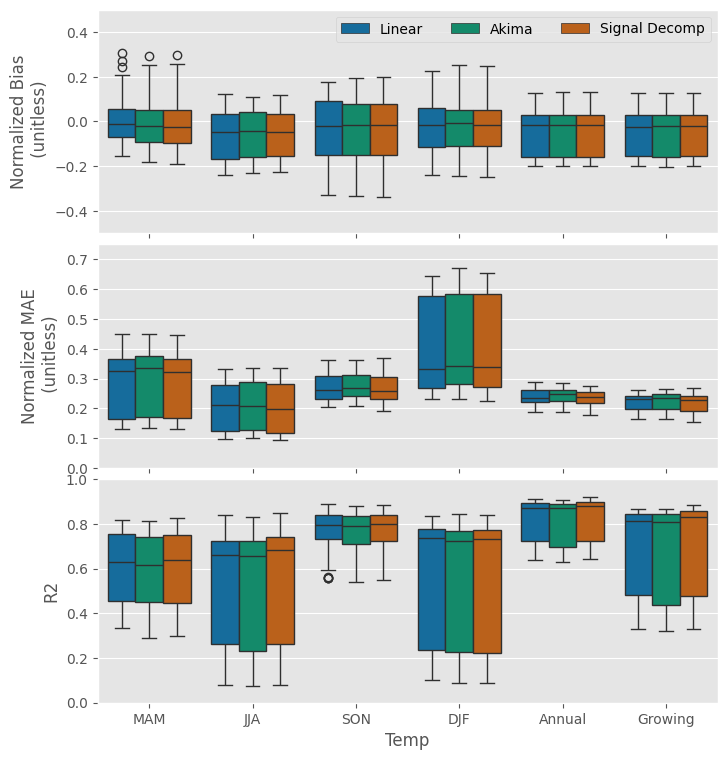

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# Load the uploaded data
data = three_site_df_ss


# Filter data for Obs_freq == 'freq_16' or 'freq_32' and selected Fill_Method
filtered_data = data[
    (data['Obs_freq'].isin(['freq_16', 'freq_32','freq_64'])) &
    (data['Fill_Method'].isin(['linear', 'Akima', 'clim_fill']))
]

filtered_data['Fill_Method'] = filtered_data.Fill_Method.map(rename_method_labels)
filtered_data['Obs_freq'] = filtered_data.Obs_freq.map(rename_labels)


# Create the plot
plt.style.use('seaborn-v0_8-colorblind')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 9), sharex=True, squeeze=True)

obs_freq = '32'
subset = filtered_data[filtered_data['Obs_freq'] == obs_freq]

stats_list = ['Bias_norm','MAE_norm','R2']
for i, stats_i in enumerate(stats_list):
    sns.boxplot(ax=axs[i], x='Temp', y=stats_i, hue='Fill_Method', data=subset)
    # axs[i].set_title(f'Obs_freq: {obs_freq}')
    # axs[i].annotate(f'Revisit frequency: {obs_freq} days', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
    # axs[i].set_ylabel('Normalized MAE (unitless)')
    if i ==2:
      axs[i].set_ylim([0,1.])
    elif i==0:
      axs[i].set_ylim([-0.5,0.5])
    else:
      axs[i].set_ylim([0,0.75])
    axs[i].legend(ncol=3)

axs[0].set_ylabel("Normalized Bias\n (unitless)")
axs[1].set_ylabel("Normalized MAE\n (unitless)")
axs[2].set_ylabel("R2")

axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[1].set_xlabel('')
plt.subplots_adjust(wspace=0, hspace=0.05)

# Save the figure and display it
plt.show()

In [ ]:
for f in ['8','16','32','64']:
  print(f)
  ss = filtered_data.loc[filtered_data['Obs_freq']==f]
  ss_gpby = ss[['Fill_Method','Temp','Bias_norm','MAE_norm','R2']].groupby(['Temp','Fill_Method']).mean()
# filtered_data#.groupby(['Obs_freq', 'Fill_Method']).mean()

8
16
32
64


In [ ]:
linear_values = subset[subset['Fill_Method'] == 'Linear'][['Bias_norm','MAE_norm','R2']].mean()
list(linear_values)

[-0.04361575993175668, 0.27563009465486005, 0.5792962829941514]

In [ ]:
# prompt: calculate the difference between values based on fill method heat plot

# Assuming 'three_site_df' DataFrame is already loaded and processed as in the provided code.

import matplotlib.pyplot as plt
import seaborn as sns

# ... (previous code)

# Calculate differences between fill methods for each statistic
for obs_freq in ['32']:
    for temp in three_site_df['Temp'].unique():
        subset = filtered_data[
            (filtered_data['Obs_freq'] == obs_freq) & (filtered_data['Temp'] == temp)
        ]
        if not subset.empty:
            # Calculate differences between fill methods
            linear_values = np.array(list(subset[subset['Fill_Method'] == 'Linear'][['Bias_norm','MAE_norm','R2']].mean()))
            akima_values = np.array(list(subset[subset['Fill_Method'] == 'Akima'][['Bias_norm','MAE_norm','R2']].mean()))
            decomp_values = np.array(list(subset[subset['Fill_Method'] == 'Signal Decomp'][['Bias_norm','MAE_norm','R2']].mean()))

            print(f"Differences for Obs_Freq: {obs_freq}, Temp: {temp}")
            print("Linear vs Akima:", linear_values - akima_values)
            print("Linear vs Decomp:", linear_values - decomp_values)
            print("Akima vs Decomp:", akima_values - decomp_values)


# Example visualization of the differences (you can customize this)
# ... (rest of the code)

Differences for Obs_Freq: 32, Temp: MAM
Linear vs Akima: [ 0.01394024 -0.00773712  0.01507193]
Linear vs Decomp: [ 0.0166165   0.00189686 -0.00096628]
Akima vs Decomp: [ 0.00267626  0.00963398 -0.01603821]
Differences for Obs_Freq: 32, Temp: JJA
Linear vs Akima: [-0.00525907 -0.0032632   0.00832269]
Linear vs Decomp: [-0.00574957  0.00448899 -0.01306889]
Akima vs Decomp: [-0.00049049  0.00775219 -0.02139158]
Differences for Obs_Freq: 32, Temp: SON
Linear vs Akima: [ 0.00309088 -0.00596079  0.00705653]
Linear vs Decomp: [ 0.00359495  0.00146222 -0.00042846]
Akima vs Decomp: [ 0.00050406  0.007423   -0.00748498]
Differences for Obs_Freq: 32, Temp: DJF
Linear vs Akima: [ 0.00012503 -0.01027708  0.00960376]
Linear vs Decomp: [-0.00015736 -0.00490572  0.00671668]
Akima vs Decomp: [-0.00028239  0.00537135 -0.00288709]
Differences for Obs_Freq: 32, Temp: Annual
Linear vs Akima: [-0.00049786 -0.00466099  0.0075165 ]
Linear vs Decomp: [-0.00064745  0.0031203  -0.00299911]
Akima vs Decomp: [-0.0

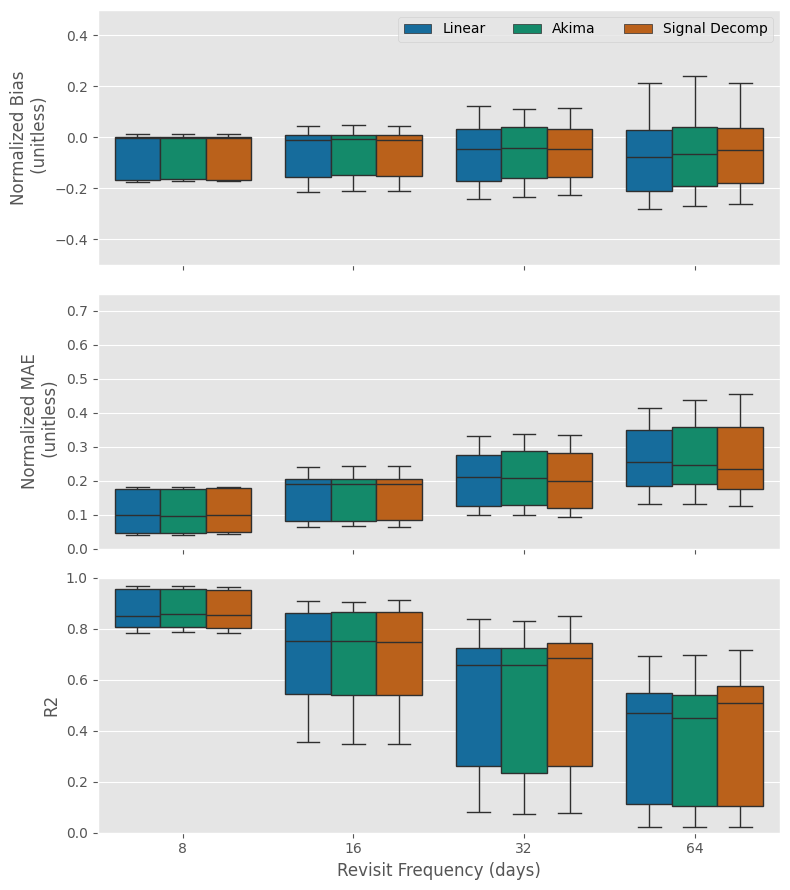

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# Load the uploaded data
data = three_site_df_ss


# Filter data for Obs_freq == 'freq_16' or 'freq_32' and selected Fill_Method
filtered_data = data[
    (data['Obs_freq'].isin(['freq_8','freq_16', 'freq_32','freq_64'])) &
    (data['Fill_Method'].isin(['linear', 'Akima', 'clim_fill']))
    ]

filtered_data['Fill_Method'] = filtered_data.Fill_Method.map(rename_method_labels)
filtered_data['Obs_freq'] = filtered_data.Obs_freq.map(rename_labels)

# Create the plot
plt.style.use('seaborn-v0_8-colorblind')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 9), sharex=True, squeeze=True)

obs_freq = 'JJA'
subset = filtered_data[filtered_data['Temp'] == obs_freq]

stats_list = ['Bias_norm','MAE_norm','R2']
for i, stats_i in enumerate(stats_list):
    sns.boxplot(ax=axs[i], x='Obs_freq', y=stats_i, hue='Fill_Method', data=subset)
    # axs[i].annotate(f'Revisit frequency: {obs_freq} days', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
    # axs[i].set_ylabel('Normalized MAE (unitless)')
    if i ==2:
      axs[i].set_ylim([0,1.])
    elif i==0:
      axs[i].set_ylim([-0.5,0.5])
    else:
      axs[i].set_ylim([0,0.75])
    axs[i].legend(ncol=3)
axs[0].set_ylabel("Normalized Bias\n (unitless)")
axs[1].set_ylabel("Normalized MAE\n (unitless)")
axs[2].set_ylabel("R2")
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[2].set_xlabel('Revisit Frequency (days)')

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
# Save the figure and display it
plt.savefig(OUT_PATH+'figures/ag_site_stats_by_method.png',dpi=400)

plt.show()
# plt.savefig(drive_ti_outpath+'/ag_site_stats_by_method.png',dpi=400)

In [ ]:
for temp_ag in time_ags:
  for mod in ['linear','Akima','clim_fill']:
    for i in [8,64]:
        print(mod,temp_ag, 'freq', i)
        print(all_stats_df.loc[(all_stats_df['Fill_Method']==mod) & (all_stats_df['Obs_freq']==f'freq_{i}') & (all_stats_df['Temp']==temp_ag)][['Bias','MAE','RMSE','R2']].mean())
        print('\n\n')


In [ ]:
# all_stats_df.loc[(all_stats_df['Fill_Method']=='linear')&(all_stats_df['Obs_freq']=='freq_16')]
# all_stats_df.loc[(all_stats_df['Fill_Method']=='linear')&(all_stats_df['Obs_freq']=='freq_32')]

In [ ]:
# # varname = 'clear_sky_EToF'
# fig,axs = plt.subplots(3,1,figsize=(3,8),sharex=True)
# ones = np.arange(-1,10,0.1)
# axs[0].plot(ones,ones,'k--')
# all_df.plot.scatter(x='ET_corr',y=varname1+'_clim_fill_ET',ax=axs[0])
# axs[1].plot(ones,ones,'k--')
# all_df.plot.scatter(x='ET_corr',y=varname1+'_linear_ET',ax=axs[1])
# axs[2].plot(ones,ones,'k--')
# all_df.plot.scatter(x='ET_corr',y=varname+'_linear_ET',ax=axs[2])
# axs[2].set_xlabel('ET$_{obs}$ (mm/day)')

In [ ]:
# print('\n\n')
# print(varname1,' linear')
# print(all_df['ET_corr'].mask(np.isnan(all_df[varname1+'_linear_ET']), np.nan).mean())
# a = stats.get_summary_stats(all_df[varname1+'_linear_ET'],all_df['ET_corr'])
# print(a)

# print('\n\n')
# print(varname,' linear')
# print(all_df['ET_corr'].mask(np.isnan(all_df[varname+'_linear_ET']), np.nan).mean())
# b = stats.get_summary_stats(all_df[varname+'_linear_ET'],all_df['ET_corr'])
# print(b)
# print('\n\n')
# print(varname, 'clim')
# print(all_df['ET_corr'].mask(np.isnan(all_df[varname+'_clim_fill_ET']), np.nan).mean())
# c = stats.get_summary_stats(all_df[varname+'_clim_fill_ET'],all_df['ET_corr'])

# print('\n\n')
# print(varname, 'Akima')
# print(all_df['ET_corr'].mask(np.isnan(all_df[varname+'_Akima_ET']), np.nan).mean())
# d = stats.get_summary_stats(all_df[varname+'_Akima_ET'],all_df['ET_corr'])


In [ ]:
# for i in np.arange(8):
#   print(i)
#   plt.figure(figsize = (6,3))
#   all_df.EToF_filtered.plot(c='black')
#   all_df[f'EToF_filtered8_{i}'].plot(style='o',markersize=4)
#   # all_df[f'etof8_'{str(i)}]=all_df[i::8]
#   # all_df[i::16].EToF_filtered.plot(style='o',markersize=3)
#   # all_df[i::32].EToF_filtered.plot(style='o',markersize=2)
#   plt.title(str(i))